<a href="https://colab.research.google.com/github/carturo6/Deep_Learning-Covid19/blob/main/LSTM_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I.A. DeepLearnin para Casos Covid-19

Este respositorio tiene el fin de predecir los proximo casos de Covid19 en México ( Nivel nacional ).

Los datos que se ocuparan, son los datos disponibles en paginas del Gobierno.
Se utilizaran solo tecnicas de Deep Learning donde cada modelo podra ir variando en funcion que los datos predichos mejor se ajusten a los datos predictorios.



## **Librerias**

In [269]:
# Import librarys.

# DC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# DL
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras import metrics


## **Importacion de datos**

In [177]:
# Carga del Dataset

df = pd.read_csv('/content/drive/MyDrive/IA_Projects/LSTM-Covid-19/owid-covid-data.csv')

In [178]:
# Seleccion a Mexico

df_mx = df[df['location'] == 'Mexico']

df_mx.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45393,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,25.0,0.000,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45394,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,97.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45395,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,186.0,0.001,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45396,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,231.0,0.002,0.000,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779
45397,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,316.0,0.002,0.001,NaN,NaN,NaN,NaN,people tested,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,75.05,0.779


In [179]:
# Seleccionando columnas
df_mx = df_mx.iloc[:, 3:6]
df_mx.head()

,date,total_cases,new_cases
45393,2020-01-01,NaN,NaN
45394,2020-01-02,NaN,NaN
45395,2020-01-03,NaN,NaN
45396,2020-01-04,NaN,NaN
45397,2020-01-05,NaN,NaN


In [180]:
df_mx = df_mx.reset_index(inplace=False)

In [181]:
del df_mx['index']

In [182]:
# Trabajando con la columna de nuevos casos

df_mx = df_mx.iloc[:,[0,2]]

## **Transformacion de los datos**

In [183]:
df_mx.head(3)

,date,new_cases
0,2020-01-01,NaN
1,2020-01-02,NaN
2,2020-01-03,NaN


In [184]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       454 non-null    object 
 1   new_cases  396 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.2+ KB


In [185]:
df_mx.date = pd.to_datetime(df_mx.date)

In [186]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       454 non-null    datetime64[ns]
 1   new_cases  396 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.2 KB


In [187]:
df_mx.describe()

,new_cases
count,396.000000
mean,5625.866162
std,4475.211614
min,0.000000
25%,2800.250000
50%,5237.500000
75%,6848.500000
max,28115.000000


In [188]:
df_mx.isna().sum()

date          0
new_cases    58
dtype: int64

In [189]:
# Quitando Datos faltantes.

df_mx = df_mx[df_mx['new_cases'].notna()]

In [190]:
df_mx.tail()

,date,new_cases
449,2021-03-25,5787.0
450,2021-03-26,5303.0
451,2021-03-27,5059.0
452,2021-03-28,1646.0
453,2021-03-29,1293.0


In [191]:
df_mx.date.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     396
unique                    396
top       2020-04-13 00:00:00
freq                        1
first     2020-02-28 00:00:00
last      2021-03-29 00:00:00
Name: date, dtype: object

## **Visualizacion de Datos**

In [192]:
df_mx_2 = df_mx.copy()

In [193]:
df_mx_2.set_index('date', inplace=True)

In [201]:
# Promedio de ventanas de tiempo

#Ventana de tiempo
ventana_tiempo = df_mx_2.rolling(7)

#Media de la ventana de tiempo
media_df = ventana_tiempo.mean()

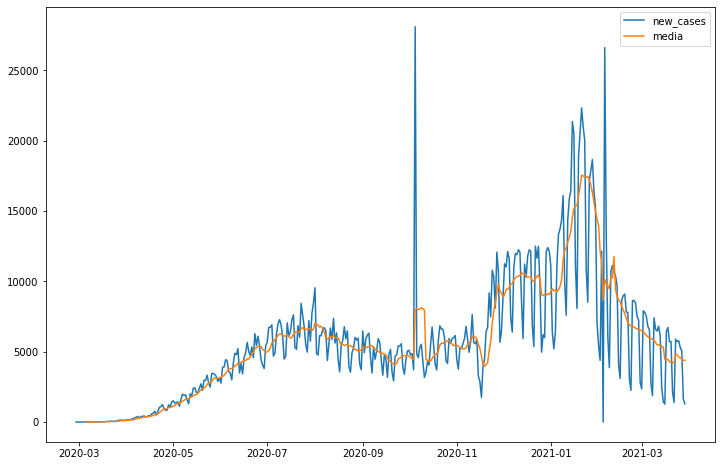

In [202]:
plt.figure(figsize=(12,8))
plt.plot(df_mx_2, label='new_cases')
plt.plot(media_df, label='media')
plt.legend()

In [196]:
seasonal_value = seasonal_decompose(df_mx_2, freq=7)

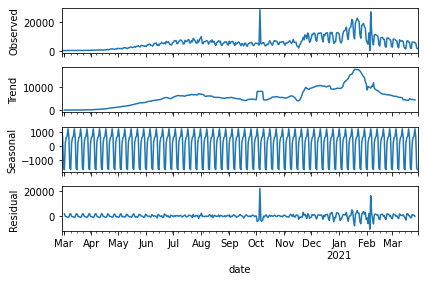

In [198]:
seasonal_value.plot();

# **Modelo-1**

In [218]:
# Datos de entreamiento y test

len(df_mx_2)

396

In [219]:
len(df_mx_2)-20

376

In [220]:
train = df_mx_2.iloc[:len(df_mx_2)-20]
test = df_mx_2.iloc[len(df_mx_2)-20:]

In [221]:
# Escalando datos

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

scaler = MinMaxScaler()

In [222]:
#Ajustando los datos de entrenamiento
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [223]:
#Datos escalados

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [242]:
# Generator
n_input = 20
n_feacture = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

x, y = generator[0]

In [243]:
# Red neuronal

#Red sequential
model_1 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_1.add(LSTM(128, activation='relu', input_shape=(n_input, n_feacture)))
model_1.add(Dense(64, activation='relu' ))
model_1.add(Dense(32))
model_1.add(Dense(1))

#Compilacion de la red nueronal
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [244]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [245]:
#Entrenando la red nueronal

model_1.fit_generator(generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 4s 14ms/step - loss: 0.0176
Epoch 2/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0112
Epoch 3/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0084
Epoch 4/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0107
Epoch 5/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0105
Epoch 6/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0100
Epoch 7/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0124
Epoch 8/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0089
Epoch 9/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0099
Epoch 10/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0168
Epoch 11/100
178/178 [==============================] - 2s 14ms/step - loss: 0.0082
Epoch 12/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0097
Epoch 13/100


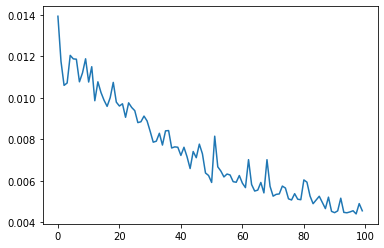

In [246]:
loss_pre_epoch = model_1.history.history['loss']
plt.plot(range(len(loss_pre_epoch)), loss_pre_epoch)

In [248]:
first_eval = scaled_train[-20:]


first_eval = first_eval.reshape(1, n_input, n_feacture)

model_1.predict(first_eval)

array([[0.2560448]], dtype=float32)

In [252]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_1.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [253]:
#Transofmacion inversa
true_predicctions = scaler.inverse_transform(test_predictions)


test['Prediction'] = true_predicctions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


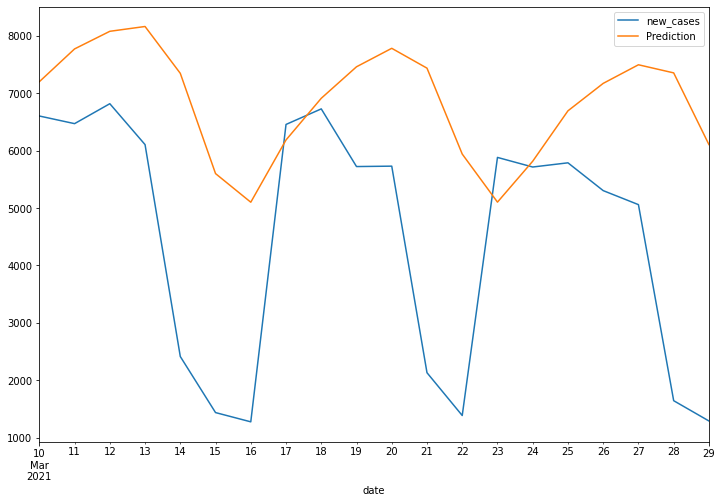

In [254]:
test.plot(figsize=(12,8))

In [256]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction
date,,
2021-03-10,6602.0,7198.699694
2021-03-11,6469.0,7769.799540
2021-03-12,6816.0,8076.432929
2021-03-13,6104.0,8160.326057
2021-03-14,2415.0,7344.734266
2021-03-15,1439.0,5599.512706
2021-03-16,1278.0,5101.249999
2021-03-17,6455.0,6185.145794
2021-03-18,6726.0,6910.484854


# **Modelo 2**

In [278]:
# Red neuronal 2
# 5 Capas
# relu para activacion de cada capa
# sgd para compilacion y mse para loss

#Red sequential
model_2 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_2.add(LSTM(128, activation='relu', input_shape=(n_input, n_feacture)))
model_2.add(Dense(64, activation='relu' ))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(12))
model_2.add(Dense(1))

#Compilacion de la red nueronal
model_2.compile(optimizer='sgd', loss='mean_squared_error', )

In [279]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 12)                396       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 13        
Total params: 77,305
Trainable params: 77,305
Non-trainable params: 0
_________________________________________________________________


In [280]:
#Entrenando la red nueronal

model_2.fit_generator(generator, epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
178/178 [==============================] - 3s 13ms/step - loss: 0.0238
Epoch 2/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0161
Epoch 3/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0168
Epoch 4/100
178/178 [==============================] - 2s 12ms/step - loss: 0.0179
Epoch 5/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0127
Epoch 6/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0098
Epoch 7/100
178/178 [==============================] - 2s 12ms/step - loss: 0.0098
Epoch 8/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0102
Epoch 9/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0113
Epoch 10/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0124
Epoch 11/100
178/178 [==============================] - 2s 13ms/step - loss: 0.0091
Epoch 12/100
178/178 [==============================] - 2s 12ms/step - loss: 0.0100
E

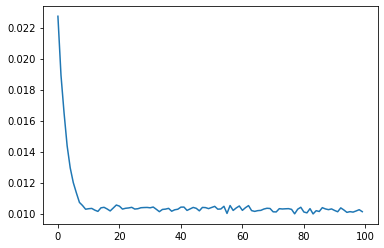

In [281]:
loss_pre_epoch = model_2.history.history['loss']
plt.plot(range(len(loss_pre_epoch)), loss_pre_epoch)

In [282]:
first_eval = scaled_train[-20:]


first_eval = first_eval.reshape(1, n_input, n_feacture)

model_2.predict(first_eval)

array([[0.18676497]], dtype=float32)

In [283]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_2.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [284]:
#Transofmacion inversa
true_predicctions_2 = scaler.inverse_transform(test_predictions)


test['Prediction_2'] = true_predicctions_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


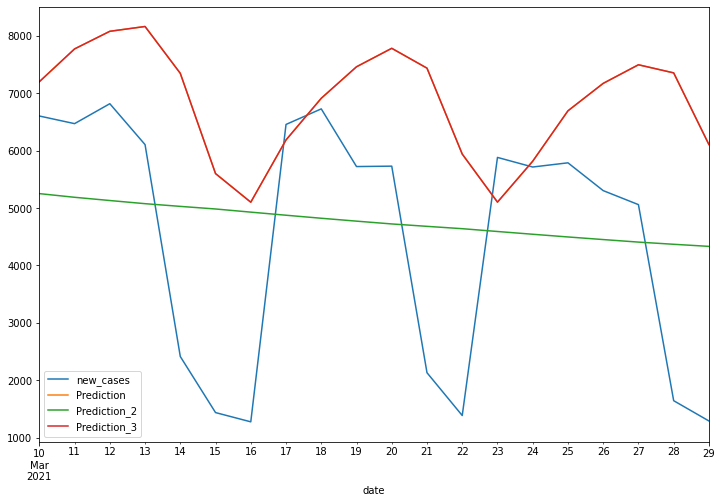

In [285]:
test.plot(figsize=(12,8))

In [286]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3
date,,,,
2021-03-10,6602.0,7198.699694,5250.897143,7198.699694
2021-03-11,6469.0,7769.799540,5186.912755,7769.799540
2021-03-12,6816.0,8076.432929,5130.660437,8076.432929
2021-03-13,6104.0,8160.326057,5075.684648,8160.326057
2021-03-14,2415.0,7344.734266,5028.705703,7344.734266
2021-03-15,1439.0,5599.512706,4983.392906,5599.512706
2021-03-16,1278.0,5101.249999,4928.503001,5101.249999
2021-03-17,6455.0,6185.145794,4874.643704,6185.145794
2021-03-18,6726.0,6910.484854,4821.941954,6910.484854


# **Modeo 3**

In [287]:
# Red neuronal 3
# 5 Capas
# relu para activacion de cada capa
# sgd para compilacion y mse para loss

#Red sequential
model_3 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_3.add(LSTM(168, activation='relu', input_shape=(n_input, n_feacture)))
model_3.add(Dense(124, activation='relu' ))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32))
model_3.add(Dense(1))

#Compilacion de la red nueronal
model_3.compile(optimizer='sgd', loss='mean_squared_error',
                metrics=[metrics.mae,
                metrics.categorical_accuracy])

In [288]:
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 168)               114240    
_________________________________________________________________
dense_28 (Dense)             (None, 124)               20956     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8000      
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 145,309
Trainable params: 145,309
Non-trainable params: 0
_________________________________________________________________


In [289]:
#Entrenando la red nueronal

model_3.fit_generator(generator, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 4s 17ms/step - loss: 0.0364 - mean_absolute_error: 0.1238 - categorical_accuracy: 1.0000
Epoch 2/100
178/178 [==============================] - 3s 17ms/step - loss: 0.0148 - mean_absolute_error: 0.0892 - categorical_accuracy: 1.0000
Epoch 3/100
178/178 [==============================] - 3s 16ms/step - loss: 0.0179 - mean_absolute_error: 0.0959 - categorical_accuracy: 1.0000
Epoch 4/100
178/178 [==============================] - 3s 17ms/step - loss: 0.0204 - mean_absolute_error: 0.0978 - categorical_accuracy: 1.0000
Epoch 5/100
178/178 [==============================] - 3s 17ms/step - loss: 0.0117 - mean_absolute_error: 0.0766 - categorical_accuracy: 1.0000
Epoch 6/100
178/178 [==============================] - 3s 17ms/step - loss: 0.0116 - mean_absolute_error: 0.0761 - categorical_accuracy: 1.0000
Epoch 7/100
178/178 [==============================] - 3s 17ms/step - loss: 0.0124 - mean_absolute_error: 0.0761 - categorical_accuracy: 1.0000
Epoc

In [290]:
first_eval_3 = scaled_train[-20:]


first_eval_3 = first_eval_3.reshape(1, n_input, n_feacture)

model_3.predict(first_eval_3)

array([[0.20016062]], dtype=float32)

In [291]:
test_predictions_3 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_3.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_3.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_3.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [292]:
#Transofmacion inversa
true_predicctions_3 = scaler.inverse_transform(test_predictions_3)


test['Prediction_3'] = true_predicctions_3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


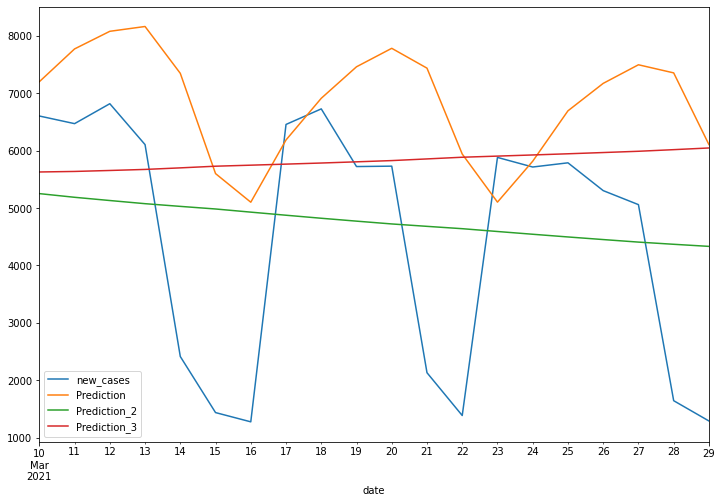

In [293]:
test.plot(figsize=(12,8))

In [294]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3
date,,,,
2021-03-10,6602.0,7198.699694,5250.897143,5627.515904
2021-03-11,6469.0,7769.799540,5186.912755,5636.928367
2021-03-12,6816.0,8076.432929,5130.660437,5653.709674
2021-03-13,6104.0,8160.326057,5075.684648,5671.982010
2021-03-14,2415.0,7344.734266,5028.705703,5699.074420
2021-03-15,1439.0,5599.512706,4983.392906,5728.060885
2021-03-16,1278.0,5101.249999,4928.503001,5746.008538
2021-03-17,6455.0,6185.145794,4874.643704,5764.402787
2021-03-18,6726.0,6910.484854,4821.941954,5783.478243


# **Modelo 4**

In [303]:
# Red neuronal 4
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_4 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_4.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_4.add(Dense(100, activation='relu' ))
model_4.add(Dense(84, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(32))
model_4.add(Dense(1))

#Compilacion de la red nueronal
model_4.compile(optimizer='adam', loss='mean_squared_error',
                metrics=[metrics.mae,
                metrics.categorical_accuracy])

In [304]:
model_4.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_36 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_37 (Dense)             (None, 84)                8484      
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2720      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 33        
Total params: 193,993
Trainable params: 193,993
Non-trainable params: 0
_______________________________________________

In [305]:
#Entrenando la red nueronal

model_4.fit_generator(generator, epochs=200)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 5s 21ms/step - loss: 0.0212 - mean_absolute_error: 0.0961 - categorical_accuracy: 1.0000
Epoch 2/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0118 - mean_absolute_error: 0.0764 - categorical_accuracy: 1.0000
Epoch 3/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0102 - mean_absolute_error: 0.0674 - categorical_accuracy: 1.0000
Epoch 4/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0107 - mean_absolute_error: 0.0662 - categorical_accuracy: 1.0000
Epoch 5/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0127 - mean_absolute_error: 0.0707 - categorical_accuracy: 1.0000
Epoch 6/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0109 - mean_absolute_error: 0.0728 - categorical_accuracy: 1.0000
Epoch 7/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0109 - mean_absolute_error: 0.0711 - categorical_accuracy: 1.0000
Epoc

In [306]:
first_eval_4 = scaled_train[-20:]


first_eval_4 = first_eval_4.reshape(1, n_input, n_feacture)

model_4.predict(first_eval_4)

array([[0.21140689]], dtype=float32)

In [307]:
test_predictions_4 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_4.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_4.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_4.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [308]:
#Transofmacion inversa
true_predicctions_4 = scaler.inverse_transform(test_predictions_4)


test['Prediction_3'] = true_predicctions_4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


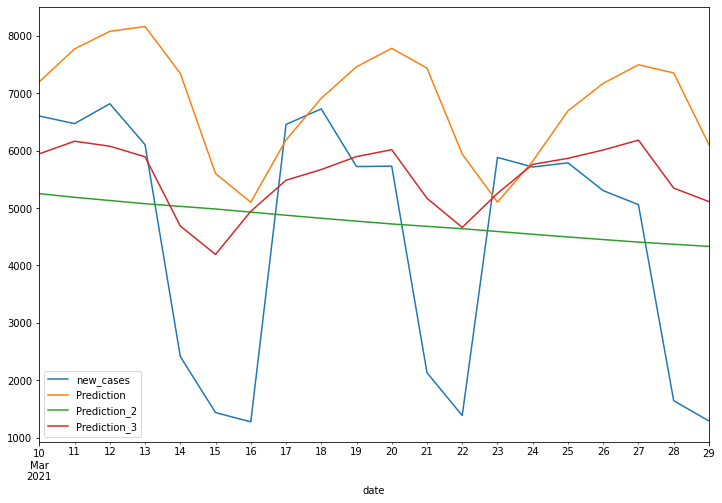

In [309]:
test.plot(figsize=(12,8))

In [310]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3
date,,,,
2021-03-10,6602.0,7198.699694,5250.897143,5943.704616
2021-03-11,6469.0,7769.799540,5186.912755,6162.998625
2021-03-12,6816.0,8076.432929,5130.660437,6076.022054
2021-03-13,6104.0,8160.326057,5075.684648,5892.415134
2021-03-14,2415.0,7344.734266,5028.705703,4686.618159
2021-03-15,1439.0,5599.512706,4983.392906,4192.284329
2021-03-16,1278.0,5101.249999,4928.503001,4942.554455
2021-03-17,6455.0,6185.145794,4874.643704,5483.946411
2021-03-18,6726.0,6910.484854,4821.941954,5669.770394


# **Model 5**

In [313]:
# Red neuronal 5
# 5 Capas
# relu para activacion de cada capa
# adam para compilacion y mse para loss

#Red sequential
model_5 = Sequential()

#Red nueronal con 4 capas, cada capa tiene dierente cantidad de nueronas
model_5.add(LSTM(200, activation='relu', input_shape=(n_input, n_feacture)))
model_5.add(Dense(100, activation='relu' ))
model_5.add(Dense(84, activation='relu'))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='sigmoid'))
model_5.add(Dense(1))

#Compilacion de la red nueronal
model_5.compile(optimizer='adam', loss='mean_squared_error',
                metrics=["accuracy"])

In [314]:
model_5.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_41 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_42 (Dense)             (None, 84)                8484      
_________________________________________________________________
dense_43 (Dense)             (None, 64)                5440      
_________________________________________________________________
dense_44 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 33        
Total params: 197,737
Trainable params: 197,737
Non-trainable params: 0
_______________________________________________

In [315]:
#Entrenando la red nueronal

model_5.fit_generator(generator, epochs=200)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


178/178 [==============================] - 6s 22ms/step - loss: 0.7586 - accuracy: 0.0036
Epoch 2/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0102 - accuracy: 7.0430e-04
Epoch 3/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0079 - accuracy: 0.0020
Epoch 4/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0111 - accuracy: 0.0057
Epoch 5/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0117 - accuracy: 8.6927e-04
Epoch 6/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0144 - accuracy: 0.0000e+00
Epoch 7/200
178/178 [==============================] - 4s 21ms/step - loss: 0.0107 - accuracy: 0.0034
Epoch 8/200
178/178 [==============================] - 4s 22ms/step - loss: 0.0094 - accuracy: 4.1903e-04
Epoch 9/200
178/178 [==============================] - 4s 22ms/step - loss: 0.0104 - accuracy: 0.0000e+00
Epoch 10/200
178/178 [==============================] - 4s 21ms/step - los

In [316]:
first_eval_5 = scaled_train[-20:]


first_eval_5 = first_eval_5.reshape(1, n_input, n_feacture)

model_5.predict(first_eval_5)

array([[0.31218523]], dtype=float32)

In [317]:
test_predictions_5 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_5.reshape((1, n_input, n_feacture))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model_5.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions_5.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [318]:
#Transofmacion inversa
true_predicctions_5 = scaler.inverse_transform(test_predictions_5)


test['Prediction_5'] = true_predicctions_5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


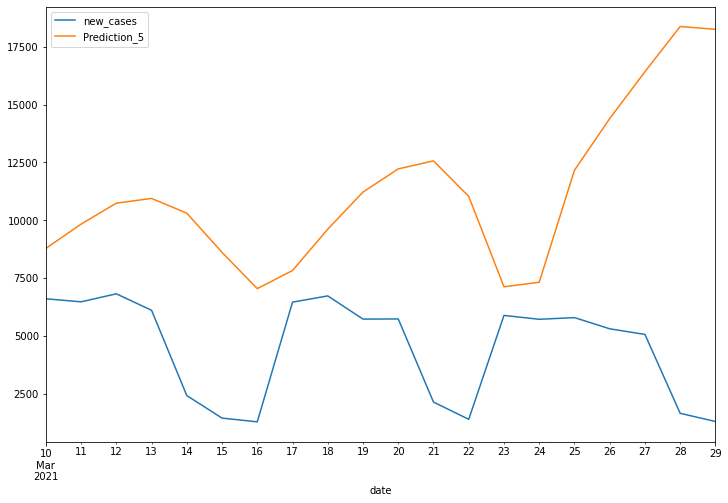

In [321]:
test[['new_cases', 'Prediction_5']].plot(figsize=(12,8))

In [320]:
#Observacion de los test y la predicciones
test

,new_cases,Prediction,Prediction_2,Prediction_3,Prediction_5
date,,,,,
2021-03-10,6602.0,7198.699694,5250.897143,5943.704616,8777.087682
2021-03-11,6469.0,7769.799540,5186.912755,6162.998625,9830.681940
2021-03-12,6816.0,8076.432929,5130.660437,6076.022054,10736.047187
2021-03-13,6104.0,8160.326057,5075.684648,5892.415134,10942.941228
2021-03-14,2415.0,7344.734266,5028.705703,4686.618159,10305.280893
2021-03-15,1439.0,5599.512706,4983.392906,4192.284329,8608.194570
2021-03-16,1278.0,5101.249999,4928.503001,4942.554455,7040.437760
2021-03-17,6455.0,6185.145794,4874.643704,5483.946411,7823.396159
2021-03-18,6726.0,6910.484854,4821.941954,5669.770394,9613.602481
